# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
list1 = []
list1.append(rewards)
list1.append(rewards)
list1array = (np.asarray(list1))

print(list1)
print(list1array)

[[0.0, -0.009999999776482582], [0.0, -0.009999999776482582]]
[[ 0.   -0.01]
 [ 0.   -0.01]]


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
from MAddpg_agent import MADDPG_Agent

import torch
import torch.nn.functional as F
import torch.optim as optim

import requests
import time

!pip install progressbar
import progressbar as pb

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [10]:
# define training configuration
episode = 2000
tmax = 2000

# declare variables for storing training results
mean_score_his = []
max_score_his = []
max_score_window = deque(maxlen=100)

# create MADDPG agent
MADDPG = MADDPG_Agent(state_size, action_size, num_agents, 20)

# print every
print_every = 10

# save every
save_every = 100

In [11]:
# main training cell

# create progress bar
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# start time tracker time
old_time = time.time()
response = requests.request("GET", 
                            "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            headers={"Metadata-Flavor":"Google"})

for e in range(episode):
    
    # check current time and old time difference, if difference is too big, send request to keep workspace alive
    if time.time() - old_time > 60:
            old_time = time.time()
            requests.request("POST", 
                             "https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             headers={'Authorization': "STAR " + response.text})
    
    
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)
    MADDPG.reset()                                        # reset action noise generator
    
    for t in range(tmax):
        action = MADDPG.act(state, True)
        env_info = env.step(action)[brain_name]  
        reward = env_info.rewards  
        next_state =  env_info.vector_observations
        done = env_info.local_done 
        score += env_info.rewards
        MADDPG.step(state, action, reward, next_state, done)
        state = next_state 
        
        if np.any(done):
            break
    mean_score_his.append(np.mean(score))
    max_score_his.append(np.max(score))
    max_score_window.append(np.max(score))
    if (e%print_every) == 0 :  
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(score)))
    
    if len(max_score_window)>=100 and np.mean(max_score_window)>=0.5:
        print("environment solved at episode {}".format(e+1))
        break
    
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()    

        
       

Episode: 1, score: -0.005000


Episode: 11, score: -0.005000


Episode: 21, score: -0.005000


Episode: 31, score: -0.005000


Episode: 41, score: -0.005000


Episode: 51, score: -0.005000


Episode: 61, score: -0.005000


Episode: 71, score: -0.005000


Episode: 81, score: -0.005000


Episode: 91, score: -0.005000


Episode: 101, score: -0.005000


Episode: 111, score: -0.005000


Episode: 121, score: -0.005000


Episode: 131, score: -0.005000


Episode: 141, score: 0.045000


Episode: 151, score: -0.005000


Episode: 161, score: 0.045000


Episode: 171, score: -0.005000


Episode: 181, score: -0.005000


Episode: 191, score: 0.045000


Episode: 201, score: -0.005000


Episode: 211, score: -0.005000


Episode: 221, score: -0.005000


Episode: 231, score: -0.005000


Episode: 241, score: -0.005000


Episode: 251, score: -0.005000


Episode: 261, score: -0.005000


Episode: 271, score: -0.005000


Episode: 281, score: 0.045000


Episode: 291, score: 0.045000


Episode: 301, score: 0.045000


Episode: 311, score: 0.045000


Episode: 321, score: 0.045000


Episode: 331, score: 0.045000


Episode: 341, score: -0.005000


Episode: 351, score: 0.045000


Episode: 361, score: 0.045000


Episode: 371, score: 0.045000


Episode: 381, score: 0.045000


Episode: 391, score: 0.045000


Episode: 401, score: 0.045000


Episode: 411, score: 0.045000


Episode: 421, score: 0.045000


Episode: 431, score: 0.045000


Episode: 441, score: 0.045000


Episode: 451, score: -0.005000


Episode: 461, score: 0.095000


Episode: 471, score: 0.045000


Episode: 481, score: 0.045000


Episode: 491, score: 0.045000


Episode: 501, score: 0.045000


Episode: 511, score: 0.045000


Episode: 521, score: 0.045000


Episode: 531, score: 0.045000


Episode: 541, score: 0.045000


Episode: 551, score: 0.045000


Episode: 561, score: 0.045000


Episode: 571, score: 0.095000


Episode: 581, score: 0.145000


Episode: 591, score: 0.045000


Episode: 601, score: 0.045000


Episode: 611, score: 0.045000


Episode: 621, score: 0.045000


Episode: 631, score: 0.145000


Episode: 641, score: 0.045000


Episode: 651, score: 0.045000


Episode: 661, score: 0.245000


Episode: 671, score: 0.195000


Episode: 681, score: 0.095000


Episode: 691, score: 0.095000


Episode: 701, score: 0.295000


Episode: 711, score: 0.145000


Episode: 721, score: 0.395000


Episode: 731, score: 0.095000


Episode: 741, score: -0.005000


Episode: 751, score: 0.395000


Episode: 761, score: 0.145000


Episode: 771, score: 0.245000


Episode: 781, score: 0.095000


Episode: 791, score: 0.195000


Episode: 801, score: 0.045000


Episode: 811, score: 0.295000


Episode: 821, score: 0.245000


Episode: 831, score: 0.095000


Episode: 841, score: 0.145000


environment solved at episode 846


In [20]:
# calculate average
max_score_mean = []
for i in reversed(range(len(max_score_his))):
    id_start = max(i-100+1,0)
    max_score_mean_temp = np.mean(max_score_his[id_start:i+1])
    max_score_mean.insert(0,max_score_mean_temp)

(<matplotlib.figure.Figure at 0x7f16cf03af60>,
 [<matplotlib.lines.Line2D at 0x7f16cf004390>])

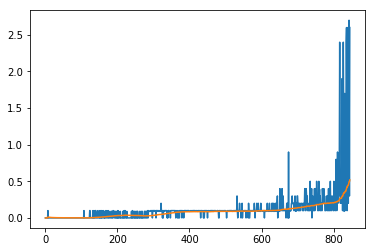

In [21]:
plt.figure(1),plt.plot(max_score_his)
plt.figure(1),plt.plot(max_score_mean)